In [2]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn.ensemble.forest import _generate_unsampled_indices
from sklearn.ensemble.forest import _generate_sample_indices

from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

In [101]:
class LifelongForest:
    """
    Lifelong Forest class.
    """
    def __init__(self, acorn=None):
        """
        Two major things the Forest Class needs access to:
            1) the realized random forest model (self.models_ is a list of forests, 1 for each task)
            2) old data (to update posteriors when a new task is introduced)
        """
        self.models_ = []
        self.X_ = []
        self.y_ = []
        self.n_tasks = 0
        self.n_classes = None
        
        if acorn is not None:
            np.random.seed(acorn)
    
    def new_forest(self, X, y, n_estimators=200, max_samples=0.32,
                        bootstrap=True, max_depth=30, min_samples_leaf=1,
                        acorn=None):
        """
        Input
        X: an array-like object of features; X.shape == (n_samples, n_features)
        y: an array-like object of class labels; len(y) == n_samples
        n_estimators: int; number of trees to construct (default = 200)
        max_samples: float in (0, 1]: number of samples to consider when 
            constructing a new tree (default = 0.32)
        bootstrap: bool; If True then the samples are sampled with replacement
        max_depth: int; maximum depth of a tree
        min_samples_leaf: int; minimum number of samples in a leaf node
        
        Return
        model: a BaggingClassifier fit to X, y
        """
        
        if X.ndim == 1:
            raise ValueError('1d data will cause headaches down the road')
            
        if acorn is not None:
            np.random.seed(acorn)
            
        self.X_.append(X)
        self.y_.append(y)
            
        n = X.shape[0]
        K = len(np.unique(y))
        
        if self.n_classes is None:
            self.n_classes = K
        
        max_features = int(np.ceil(np.sqrt(X.shape[1])))

        model=BaggingClassifier(DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf,
                                                         max_features = max_features),
                                  n_estimators=n_estimators,
                                  max_samples=max_samples,
                                  bootstrap=bootstrap)

        model.fit(X, y)
        self.models_.append(model)
        self.n_tasks += 1
        self.n_classes = len(np.unique(y))
        
        return model
    
    
    def _get_leaves(self, estimator):
        """
        Internal function to get leaf node ids of estimator.
        
        Input
        estimator: a fit DecisionTreeClassifier
        
        Return
        leaf_ids: numpy array; an array of leaf node ids
        
        Usage
        _estimate_posteriors(..)
        """
        
        # adapted from https://scikit-learn.org/stable/auto_examples/tree/plot_unveil_tree_structure.html
        n_nodes = estimator.tree_.node_count
        children_left = estimator.tree_.children_left
        children_right = estimator.tree_.children_right
        feature = estimator.tree_.feature
        threshold = estimator.tree_.threshold

        leaf_ids = []
        stack = [(0, -1)] 
        while len(stack) > 0:
            node_id, parent_depth = stack.pop()

            # If we have a test node
            if (children_left[node_id] != children_right[node_id]):
                stack.append((children_left[node_id], parent_depth + 1))
                stack.append((children_right[node_id], parent_depth + 1))
            else:
                leaf_ids.append(node_id)

        return np.array(leaf_ids)
    
    
    def _finite_sample_correction(self, class_probs, row_sums):
        """
        An internal function for finite sample correction of posterior estimation.
        
        Input
        class_probs: numpy array; array of posteriors to correct
        row_sums: numpy array; array of partition counts
        
        Output
        class_probs: numpy array; finite sample corrected posteriors
        
        Usage
        _estimate_posteriors(..)
        
        """
    
        where_0 = np.argwhere(class_probs == 0)
        for elem in where_0:
            class_probs[elem[0], elem[1]] = 1 / (2 * row_sums[elem[0], None])
        where_1 = np.argwhere(class_probs == 1)
        for elem in where_1:
            class_probs[elem[0], elem[1]] = 1 - 1 / (2 * row_sums[elem[0], None])
    
        return class_probs
    
    
    def _estimate_posteriors(self, test, task_number, in_task=True, subsample=1, acorn=None):
        """
        An internal function to estimate the posteriors.
        
        Input
        task_number: int; indicates which model in self.model_ to use
        test: array-like; test observation
        in_task: bool; True if test is an in-task observation(s)
        subsample: float in (0, 1]; proportion of out-of-task samples to use to
            estimate posteriors
            
        Return
        probs: numpy array; probs[i, k] is the probability of observation i
            being class k
            
        Usage
        predict(..)
        """
        
        if acorn is not None:
            acorn = np.random.seed(acorn)
            
        train = self.X_[task_number]
        y = self.y_[task_number]
            
        model = self.models_[task_number]

        n, d = train.shape
        
        if test.ndim > 1:
            m, d_ = test.shape
        else:
            m = len(test)
            d_ = 1

        class_counts = np.zeros((m, model.n_classes_))
        for tree in model:
            # get out of bag indicies
            if in_task:
                prob_indices = _generate_unsampled_indices(tree.random_state, n)
                # in_bag_idx = _generate_sample_indices(tree.random_state, n) # this is not behaving as i expected
            else:
                prob_indices = np.random.choice(range(n), size=int(subsample*n), replace=False)

            leaf_nodes = self._get_leaves(tree)
            unique_leaf_nodes = np.unique(leaf_nodes)

            # get all node counts
            node_counts = tree.tree_.n_node_samples
            # get probs for eval samples
            posterior_class_counts = np.zeros((len(unique_leaf_nodes), model.n_classes_))

            for prob_index in prob_indices:
                temp_node = tree.apply(train[prob_index].reshape(1, -1)).item()
                posterior_class_counts[np.where(unique_leaf_nodes == temp_node)[0][0], y[prob_index]] += 1

            # total number of points in a node
            row_sums = posterior_class_counts.sum(axis=1)

            # no divide by zero
            row_sums[row_sums == 0] = 1

            # posteriors
            class_probs = (posterior_class_counts / row_sums[:, None])
            # posteriors with finite sampling correction

            class_probs = self._finite_sample_correction(class_probs, row_sums)

            # posteriors as a list
            class_probs.tolist()

            partition_counts = np.asarray([node_counts[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)])
            # get probability for out of bag samples
            eval_class_probs = [class_probs[np.where(unique_leaf_nodes == x)[0][0]] for x in tree.apply(test)]
            eval_class_probs = np.array(eval_class_probs)
            # find total elements for out of bag samples
            elems = np.multiply(eval_class_probs, partition_counts[:, np.newaxis])
            # store counts for each x (repeat fhis for each tree)
            class_counts += elems
        # calculate p(y|X = x) for all x's
        probs = class_counts / class_counts.sum(axis=1, keepdims=True)

        return probs


    def predict(self, test, task_number=-1, subsample=1, single_task=False, acorn=None):
        """
        Predicts the class labels for each sample in test.
        
        Input
        test: array-like; either a 1d array of length n_features
            or a 2d array of shape (m, n_features) 
        task_number: int; task number """
        sum_posteriors = np.zeros((test.shape[0], self.n_classes))
        
        if single_task:
            sum_posteriors += self._estimate_posteriors(test,
                                                        task_number,
                                                        True,
                                                        subsample,
                                                        acorn)
        else:
            for i in range(self.n_tasks):
                if task_number == i:
                    sum_posteriors += self._estimate_posteriors(test,
                                                                task_number,
                                                                True,
                                                                subsample,
                                                                acorn)
                else:
                    sum_posteriors += self._estimate_posteriors(test,
                                                                task_number,
                                                                False,
                                                                subsample,
                                                                acorn)
        return np.argmax(sum_posteriors, axis=1)

In [9]:
def generate_2d_rotation(theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
    
    R = np.array([
        [np.cos(theta), np.sin(theta)],
        [-np.sin(theta), np.cos(theta)]
    ])
    
    return R

def generate_parity(n, d=2, theta=0, acorn=None):
    if acorn is not None:
        np.random.seed(acorn)
        
    X = np.random.uniform(-1, 1, size=(n, d))
    Y = (np.sum(X > 0, axis=1) % 2 == 0).astype(int)
    
    if d == 2:
        R = generate_2d_rotation()
        X = X @ R
    
    return X, Y.astype(int)

In [8]:
def jovo_experiment(nx, nz, d, dist_x=generate_parity, dist_z=generate_parity, theta=0, m=100, subsample = 0.32, n_algos=6, return_posteriors = False):
#     Tx = int(np.floor(np.sqrt(nx)))
#     Tz = int(np.floor(np.sqrt(nz)))

    Tx = 1
    Tz = 1
    
    Kx = int(np.floor(np.log(nx)))
    Kz = int(np.floor(np.log(nz)))
    
    errors = np.zeros(n_algos)

    # Source task
    X, labelsX = dist_x(nx, d)
    testX, test_labelsX = dist_x(m, d)
    
    # Target task
    Z, labelsZ = dist_z(nz, d)
    testZ, test_labelsZ = dist_z(m, d)
    
    if len(X[0, :]) == 2:
        R = generate_2d_rotation(theta)
    else:
        R = generate_3d_rotation()
        
    Z = Z @ R
    testZ = testZ @ R

    model_X = build_model(X, labelsX, Tx)
    model_Z = build_model(Z, labelsZ, Tz)

    posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, testX, in_task=True)
    posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, testX, in_task=False, subsample=subsample)

    pred_structX_estX=predict(posteriors_structX_estX)
    pred_structZ_estX=predict(posteriors_structZ_estX)

    posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, testZ, in_task=False, subsample=subsample)
    posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, testZ, in_task=True)
    
    pred_structX_estZ=predict(posteriors_structX_estZ)
    pred_structZ_estZ=predict(posteriors_structZ_estZ)

    # calculate errors without attempting to transfer knowledge
    pred_X = predict(posteriors_structX_estX)
    pred_Z = predict(posteriors_structZ_estZ)

    errors[0] = 1 - np.sum(test_labelsX == pred_X)/m
    errors[3] = 1 - np.sum(test_labelsZ == pred_Z)/m
    
    errors[1] = 1 - np.sum(test_labelsX == pred_structZ_estX)/m
    errors[4] = 1 - np.sum(test_labelsZ == pred_structX_estZ)/m

    # jtv ?
    pred_X_jtv = predict(posteriors_structX_estX + posteriors_structZ_estX)
    pred_Z_jtv = predict(posteriors_structZ_estZ + posteriors_structX_estZ)

    errors[2] = 1 - np.sum(test_labelsX == pred_X_jtv)/m
    errors[5] = 1 - np.sum(test_labelsZ == pred_Z_jtv)/m
    
    if return_posteriors:
        # returns posteriors for a fixed mesh..
        mesh_ =np.array(list(itertools.product(np.arange(-4, 4+0.05, step=0.05), np.arange(-4, 4+0.05, step=0.05))))
        
        posteriors_structX_estX=estimate_posteriors(model_X, X, labelsX, mesh_, in_task=True)
        posteriors_structZ_estX=estimate_posteriors(model_Z, X, labelsX, mesh_, in_task=False, subsample=subsample)

        posteriors_structX_estZ=estimate_posteriors(model_X, Z, labelsZ, mesh_, in_task=False, subsample=subsample)
        posteriors_structZ_estZ=estimate_posteriors(model_Z, Z, labelsZ, mesh_, in_task=True)
                    
        return posteriors_structX_estX, posteriors_structZ_estX, posteriors_structZ_estZ, posteriors_structX_estZ
    else:
        return errors

In [ ]:
# This block runs parity experiments for exactly two tasks. 
# The experiments take a while, so i always run them on syntaptomes 1/2

from tqdm import tqdm
np.random.seed(1)
from joblib import Parallel, delayed

mc_its = 50 # number of simulation repititions
ns = (100*np.arange(0.5, 4.5, step=0.5)).astype(int) # number of training samples 

m = 100 # number of test samples each monte carlo iteration

algorithms = ['Decision Forest XOR', 'Decision Forest N-XOR', 'Lifelong Forests']
algorithms = np.concatenate((algorithms, ['Decision Forest N-XOR', 'Decision Forest XOR', 'Lifelong Forests']))

M = len(algorithms)

mean_error = np.zeros((M, len(ns)))
std_error = np.zeros((M, len(ns)))

d = 2
for j, n in enumerate(tqdm(ns)):
    condensed_func = lambda x : jovo_experiment(100, x, d, theta=np.pi, m=m, n_algos=M)
    
    errors = np.array(Parallel(n_jobs=-2)(delayed(condensed_func)(int(x)) for x in n*np.ones(mc_its)))
    
    mean_error[:, j] = np.mean(errors, axis=0)
    std_error[:, j] = np.std(errors, ddof=1, axis=0)

In [ ]:
# plotting cell.. 

import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.gridspec as gridspec

gs1 = gridspec.GridSpec(4, 4)
sns.set()

mc_it = mc_its

sns.set(font_scale=1.5)
colors = sns.color_palette("Set1", n_colors = M)
    
algo_offset=0
names = ['rf', 'transfer', 'lifelong']
for j, name in enumerate(names):
    fig1 = plt.figure(figsize=(8,8))
    ax3 = fig1.add_subplot(1,1,1)
    for i, algo in enumerate(algorithms[:j+1]):
        ax3.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i])
        ax3.fill_between(ns, 
                mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
                mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
                where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
                facecolor=colors[i], 
                alpha=0.15,
                interpolate=True)
    ax3.set_ylabel('Error (XOR)')
    ax3.legend(loc='upper center', fontsize=15)
    ax3.set_ylim(-0.01, 0.3)

    fig1.subplots_adjust(wspace=0.1, hspace=0.15)

    fig1.text(0.5, 0.04, 'N-XOR Sample Size', ha='center')
#     plt.savefig('L2M_18mo_xor_nxor_%s.png'%(name))
    
algo_offset=3
for j, name in enumerate(names):
    fig1 = plt.figure(figsize=(8,8))

    ax3 = fig1.add_subplot(1,1,1)
    for i, algo in enumerate(algorithms[algo_offset:algo_offset+j+1]):
        ax3.plot(ns, mean_error[i + algo_offset], label=algo, c=colors[i + algo_offset])
        ax3.fill_between(ns, 
                mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
                mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
                where=mean_error[i + algo_offset] + 1.96*std_error[i + algo_offset]/np.sqrt(mc_it) >= mean_error[i + algo_offset] - 1.96*std_error[i + algo_offset]/np.sqrt(mc_it), 
                facecolor=colors[i +algo_offset], 
                alpha=0.15,
                interpolate=True)
    ax3.set_ylabel('Error (N-XOR)')
    
    ax3.legend(loc='upper center', fontsize=15)
    ax3.set_ylim(-0.01, 0.3)

    fig1.subplots_adjust(wspace=0.1, hspace=0.15)

    fig1.text(0.5, 0.04, 'N-XOR Sample Size', ha='center')
#     plt.savefig('L2M_18mo_nxor_xor_%s.png'%(name))

In [116]:
# Stuff in action
from tqdm import tqdm

nmc=100 # n monte carlo iterations
# ns=[75, 100, 125, 150, 200] # amount of data from each task 
ns = 5*[75]
m=300 # amount of data from each task to estimate the risk
d=2 # dimension of parity problem

h=0.125
fracs = np.arange(0, 0.5+h,step=h) 
thetas = np.pi*fracs
n_tasks = len(thetas)

accuracies = [np.zeros((nmc, len(thetas) - i)) for i in range(n_tasks)]
STL_accuracies = [np.zeros((nmc, len(thetas) - i)) for i in range(n_tasks)]
ratios = [np.zeros((nmc, len(thetas) - i)) for i in range(n_tasks)]

for _ in tqdm(range(nmc)):
    L2F = LifelongForest()
    for i, th in enumerate(thetas):
        temp_X, temp_y = generate_parity(ns[i], d, th, acorn=_*i)
        L2F.new_forest(temp_X, temp_y, n_estimators=int(np.sqrt(n)))

        for j in range(i+1):
            test_X, test_y = generate_parity(m, d, thetas[j], acorn=_*i + j + 1)
            predictions = L2F.predict(test_X, task_number=j)
            accuracy = np.sum(predictions == test_y) / m
            accuracies[j][_, i-j] = accuracy
            STL_accuracies[j][_, i-j] = np.sum(L2F.predict(test_X, task_number=j, single_task=True) == test_y)/m
            
            ratios[j][_, i-j] = (1 - accuracies[j][_, i-j]) / (1 - STL_accuracies[j][_, i-j])


100%|██████████| 100/100 [04:14<00:00,  2.43s/it]

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


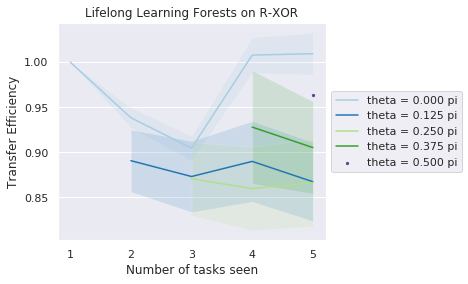

In [119]:
import seaborn as sns
sns.set()

# mean_accuracies = [1 - np.mean(accuracies[i],axis=0) for i in range(n_tasks)]
# std_accuracies = [np.std(accuracies[i],ddof=1,axis=0) for i in range(n_tasks)]

# STL_mean_accuracies = [1 - np.mean(STL_accuracies[i],axis=0) for i in range(n_tasks)]
# STL_std_accuracies = [np.std(STL_accuracies[i],ddof=1,axis=0) for i in range(n_tasks)]

mean_ratios = [np.mean(ratios[i],axis=0) for i in range(n_tasks)]
std_ratios = [np.std(ratios[i],ddof=1,axis=0) for i in range(n_tasks)]


fig, ax = plt.subplots(1,1)
c = sns.color_palette('Paired', n_colors=10)
for i in range(n_tasks - 1):
    ns = np.arange(i + 1, n_tasks + 1)
#     ax.plot(ns,(1 - np.array(mean_accuracies[i])), label = 'theta = %1.3f pi'%(fracs[i]), c=c[i])
    ax.plot(ns, mean_ratios[i], label = 'theta = %1.3f pi'%(fracs[i]), c=c[i])
    
    ax.fill_between(np.arange(i+1, n_tasks+1), 
        mean_ratios[i] + 1.96*std_ratios[i]/np.sqrt(nmc), 
        mean_ratios[i] - 1.96*std_ratios[i]/np.sqrt(nmc), 
        where=mean_ratios[i] + 1.96*std_ratios[i]/np.sqrt(nmc) >= mean_ratios[i] - 1.96*std_ratios[i]/np.sqrt(nmc), 
        facecolor=c[i], 
        alpha=0.15,
        interpolate=True)
    
    
ax.scatter(n_tasks, (1 - mean_accuracies[-1]), c = c[9], label='theta = %1.3f pi'%(fracs[-1]), s = 5)
    
ax.set_title('Lifelong Learning Forests on R-XOR')
ax.set_xlabel('Number of tasks seen')
ax.set_ylabel('Transfer Efficiency')
# ax.set_ylim(0.05 - 0.01, 0.5 + 0.01)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
# ax.set_yticks([1, 0.95, 0.90, 0.85, 0.80])
ax.set_xticks(np.arange(1,n_tasks+1))
ax.grid(axis='x')
plt.savefig('rxors_lifelong_equaln_03112019.png')